In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
N_POINTS = 200
y = np.linspace(0, 1, N_POINTS)
eps = np.random.uniform(-0.1, 0.1, size=N_POINTS)
x = y + 0.3 * np.sin(2*np.pi*y) + eps

y = y[np.argsort(x)]
x = x[np.argsort(x)]

Text(0.5, 0, 'x')

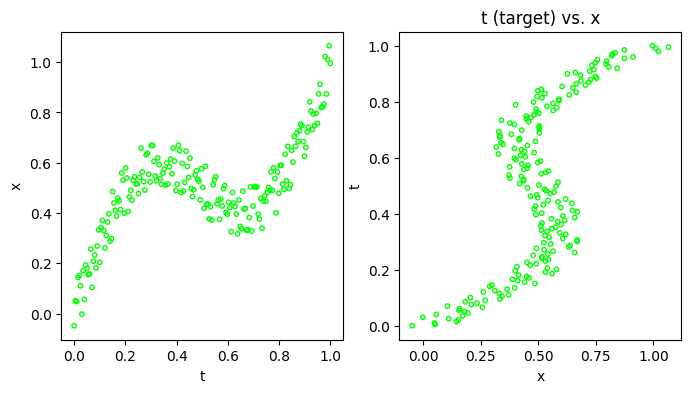

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].scatter(y, x, s=10, facecolors="none", edgecolors="lime")
ax[0].set_xlabel("t")
ax[0].set_ylabel("x")

ax[1].scatter(x, y, s=10, facecolors="none", edgecolors="lime")
ax[1].set_title("t (target) vs. x")
ax[1].set_ylabel("t")
ax[1].set_xlabel("x")

In [4]:
class Network(nn.Module):
    def __init__(self, h=10, k=3, init_=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
        self.input = nn.Linear(1, h)            # Input Layer
        self.activation = nn.Tanh()

        self.pi_layer = nn.Linear(h, k)         # Mixing Weights Layer
        self.pi_activation = nn.Softmax(dim=1)

        self.mu_layer = nn.Linear(h, k)         # Means layer - no activation needed

        self.sigma_layer = nn.Linear(h, k)      # Variance layer - needs an activation in the forward function

    def forward(self, x):
        out = self.input(x)
        out = self.activation(out)
        # Mixing Coefficients
        pi = self.pi_layer(out)
        pi = self.pi_activation(pi)
        # Means
        mu = self.mu_layer(out)
        # Sigma
        sigmasq = self.sigma_layer(out)
        sigmasq = torch.exp(sigmasq)

        return pi, mu, sigmasq

    def predict(self, x):
        with torch.no_grad():
            pi, mu, sigma = self.forward(x)

        max_arg = torch.argmax(pi, axis=1)

        ret_pred = torch.empty_like(x)
        for i, a in enumerate(max_arg):
            ret_pred[i] = mu[i,a]

        return ret_pred 

In [5]:
x_t = torch.tensor(x.reshape(-1,1), dtype=torch.float32)
y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

Loss function

$
E(w) = - \sum_{N} \ln \{ \sum_{K} \pi_{k} N(t_n | \mu_{k}(x_{n}, w), \sigma^{2}_{k} (x_{n}, w) ) \}
$

Torch, and other autodiff libraries, can perform the autodifferentiation of this function

In [6]:
def gaussian_pdf(mu, sigma, y):
    likelihood = torch.exp(-torch.pow(y - mu, 2) / (2 * sigma * sigma)) / (sigma * np.sqrt(2 * torch.pi) )
    return likelihood 

def loss_fn(pi, mu, sigmasq, y):
    likelihood = gaussian_pdf(mu, sigmasq, y)
    loss = torch.sum(torch.log(torch.sum(pi * likelihood, dim=1)))
    return -loss

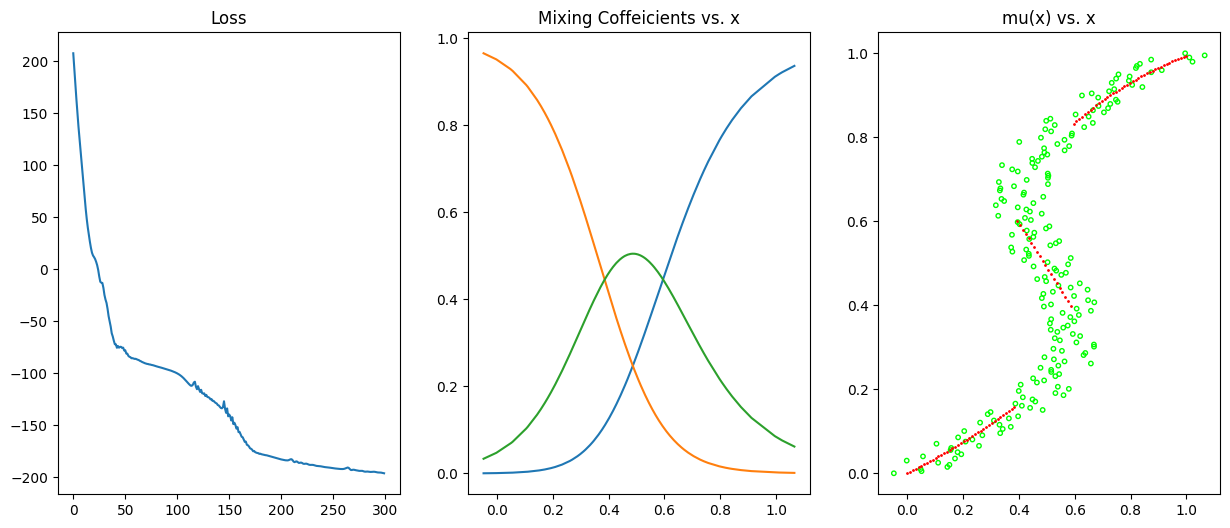

In [7]:
k = 3
network = Network(k=3)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-2)

losses = []
for e in range(0, 300):
    optimizer.zero_grad()

    pi, mu, sigmasq = network.forward(x_t)
    loss = loss_fn(pi, mu, sigmasq, y_t)

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

with torch.no_grad():
    pi_pred, mu_pred, sigma_pred = network.forward(x_t)

x_t_test = torch.linspace(0, 1, 100).reshape(-1,1)
y_pred = network.predict(x_t_test)

fig, ax = plt.subplots(1, 3, figsize=(15,6))
ax[0].plot(losses)
ax[0].set_title("Loss")
ax[1].set_title("Mixing Coffeicients vs. x")
for i in range(k):
    ax[1].plot(x_t, pi_pred[:,i])

ax[2].set_title("mu(x) vs. x")
ax[2].scatter(x_t, y_t, s=10, facecolors="none", edgecolors="lime")
ax[2].scatter(x_t_test, y_pred, s=1, color="red")
